In [1]:
from dataclasses import dataclass
import numpy as np
import seaborn as sns
from scipy.integrate import quad, trapz

In [2]:
# W m–2 ppbv-1
radiative_efficieny_ppbv = {"co2": 1.37e-5, "ch4": 3.63e-4, "n2o": 3.00e-3}

def ppbv_to_kg_conversion(ghg):
    """
    Convert the radiative efficiency from ppbv normalization to kg normalization.
    
    References
    --------------
    IPCC 2013. AR5, WG1, Chapter 8 Supplementary Material. p. 8SM-15.
    https://www.ipcc.ch/report/ar5/wg1/
    """
    # kg per kmol
    molecular_weight = {"co2": 44.01, "ch4": 16.04, "n2o": 44.013}
    
    total_mass_atmosphere = 5.1352e18 # kg
    mean_molecular_weight_air = 28.97 # kg per kmol
    molecular_weight_ghg = molecular_weight[ghg]
    mass_ratio = mean_molecular_weight_air/molecular_weight_ghg
    return mass_ratio * (1e9/total_mass_atmosphere)
    
def get_radiative_efficieny_kg(ghg):
    """Get the radiative efficiency of a GHG in W m–2 kg–1.
    """
    ppv_to_kg = ppbv_to_kg_conversion(ghg)
    return ppv_to_kg * radiative_efficieny_ppbv[ghg]

In [3]:
def CO2_irf(time_horizon):
    """The impulse response function of CO2.
    
    Parameters
    -----------
    time_horizon : int
        The time since the original CO2 emission occured.
    
    References
    --------------
    IPCC 2013. AR5, WG1, Chapter 8 Supplementary Material. Equation 8.SM.10
    https://www.ipcc.ch/report/ar5/wg1/
    
    """
    a0 = 0.2173
    a1 = 0.2240
    a2 = 0.2824
    a3 = 0.2763
    
    t_1 = 394.4
    t_2 = 36.54
    t_3 = 4.304
    
    exponential_1 =  np.exp(-time_horizon/t_1)
    exponential_2 = np.exp(-time_horizon/t_2)
    exponential_3 = np.exp(-time_horizon/t_3)
    
    return a0 + a1*exponential_1 + a2*exponential_2 + a3*exponential_3


def impulse_response_function(time_horizon, ghg):
    """The impulse response function for different GHGs.
    
    References
    -----------
    IPCC 2013. AR5, WG1, Chapter 8 Supplementary Material. Equation 8.SM.8.
    https://www.ipcc.ch/report/ar5/wg1/
    """
    # time_horizon = np.arange(time_horizon)
    life_time = {"ch4": 12.4, "n2o": 121}
    if ghg.lower() == "co2":
        return CO2_irf(time_horizon)
    else:
        
        return np.exp(-time_horizon/life_time[ghg.lower()])

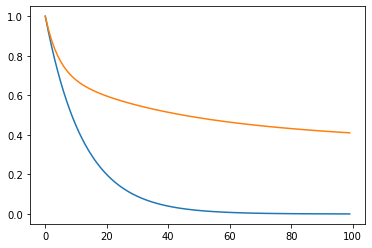

In [4]:
time = 100
time_horizon = np.arange(time)
sns.lineplot(time_horizon, impulse_response_function(time_horizon, "CH4"))
sns.lineplot(time_horizon, impulse_response_function(time_horizon, "CO2"))

In [5]:
def AGWP_CO2(t):
    radiative_efficiency = get_radiative_efficieny_kg("co2")
    
    a0 = 0.2173
    a1 = 0.2240
    a2 = 0.2824
    a3 = 0.2763
    
    t1 = 394.4
    t2 = 36.54
    t3 = 4.304
    
    exponential_1 =  1 - np.exp(-t/t1)
    exponential_2 = 1 - np.exp(-t/t2)
    exponential_3 = 1 - np.exp(-t/t3)
    cumulative_concentration = a0*t + a1*t1*exponential_1 + a2*t2*exponential_2 + a3*t3*exponential_3 
    return radiative_efficiency * cumulative_concentration


def AGWP_CH4_no_CO2(t):
    """
    Note
    ------
    Does not include indirect effects from CO2 as a result of CH4 conversion to CO2.
    """
    indirect_O3 = 0.5
    indirect_H2O = 0.15
    life_time = 12.4
    radiative_efficiency = get_radiative_efficieny_kg("ch4") * (1+indirect_O3+indirect_H2O)
    
    return radiative_efficiency * life_time * (1 - np.exp(-t/life_time))

In [6]:
def test_AGWP():
    """
    References
    ----------
    IPCC, 2013. AR5, WG1, Chapter 8.  Appendix 8.A.
    https://www.ipcc.ch/report/ar5/wg1/
    """
    assert np.isclose(AGWP_CO2(100)/9.17e-14, 1, atol=1e-02)
    assert np.isclose(AGWP_CO2(20)/2.49e-14, 1, atol=1e-02)
    assert np.isclose(AGWP_CH4_no_CO2(20)/2.09e-12, 1, atol=1e-03)
    assert np.isclose(AGWP_CH4_no_CO2(100)/2.61e-12, 1, atol=1e-03)
    
test_AGWP()

## Comparing numerical accuracy of integration with analytical solution

In [7]:
# analytical solution
AGWP_CH4_no_CO2(100)

2.6113339465675214e-12

In [8]:
# AGWP quad integration
adjustment_for_O3_and_H2O = 1.65
quad(impulse_response_function, 0, 100, args=("ch4"))[0] * get_radiative_efficieny_kg("ch4") * adjustment_for_O3_and_H2O

2.6113339465675218e-12

In [9]:
# AGWP trapz integration
trapz(impulse_response_function(np.arange(100), "ch4")) * get_radiative_efficieny_kg("ch4") * adjustment_for_O3_and_H2O

2.612680023606507e-12